In [1]:
mscoco_category2name = {1: "person",
    2: "bicycle",
    3: "car",
    4: "motorcycle",
    5: "airplane",
    6: "bus",
    7: "train",
    8: "truck",
    9: "boat",
    10: "traffic light",
    11: "fire hydrant",
    13: "stop sign",
    14: "parking meter",
    15: "bench",
    16: "bird",
    17: "cat",
    18: "dog",
    19: "horse",
    20: "sheep",
    21: "cow",
    22: "elephant",
    23: "bear",
    24: "zebra",
    25: "giraffe",
    27: "backpack",
    28: "umbrella",
    31: "handbag",
    32: "tie",
    33: "suitcase",
    34: "frisbee",
    35: "skis",
    36: "snowboard",
    37: "sports ball",
    38: "kite",
    39: "baseball bat",
    40: "baseball glove",
    41: "skateboard",
    42: "surfboard",
    43: "tennis racket",
    44: "bottle",
    46: "wine glass",
    47: "cup",
    48: "fork",
    49: "knife",
    50: "spoon",
    51: "bowl",
    52: "banana",
    53: "apple",
    54: "sandwich",
    55: "orange",
    56: "broccoli",
    57: "carrot",
    58: "hot dog",
    59: "pizza",
    60: "donut",
    61: "cake",
    62: "chair",
    63: "couch",
    64: "potted plant",
    65: "bed",
    67: "dining table",
    70: "toilet",
    72: "tv",
    73: "laptop",
    74: "mouse",
    75: "remote",
    76: "keyboard",
    77: "cell phone",
    78: "microwave",
    79: "oven",
    80: "toaster",
    81: "sink",
    82: "refrigerator",
    84: "book",
    85: "clock",
    86: "vase",
    87: "scissors",
    88: "teddy bear",
    89: "hair drier",
    90: "toot"
}

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt

In [3]:
import argparse
from src.solver import TASKS
from src.core import YAMLConfig

config = '/home/prml3090/joohee/RM-DETR/configs/rm-detr/r18_250311_3090.yml'
pt_path = '/home/prml3090/joohee/RM-DETR/output/r18_0312/best.pth'
cfg = YAMLConfig(
       config, resume=pt_path, use_amp=False, tuning=False
    )
solver = TASKS[cfg.yaml_cfg["task"]](cfg)
print(solver)

In [4]:
device = "cuda"
solver.setup
solver.eval()
model = solver.model
model.to(device)
model.eval()
postprocessor = solver.postprocessor
print(postprocessor)

Load PResNet18 state_dict
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
resume from /home/prml3090/joohee/RM-DETR/output/r18_0312/best.pth
Loading last_epoch
Loading model.state_dict
Loading ema.state_dict
RMDETRPostProcessor(use_focal_loss=True, num_classes=80, num_top_queries=300)


In [5]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random

def get_distinct_colors(n):
    """
    n개의 객체에 대해 시각적으로 구분 가능한 색상 리스트 생성
    """
    colors = plt.cm.get_cmap('tab20', n)
    return [tuple((np.array(colors(i)[:3]) * 255).astype(int)) for i in range(n)]

def visualize_all_high_score_objects(post_output, image_path, score_threshold=0.5):
    """
    점수 0.5 이상인 객체들을 모두 시각화 (마스크, 박스, 클래스, 점수 포함)

    Args:
        post_output (dict): 후처리 결과 (labels, boxes, scores, masks)
        image_path (str): 이미지 파일 경로
        score_threshold (float): 시각화할 최소 점수 임계값
    """
    labels = post_output['labels'].detach().cpu().numpy()
    boxes = post_output['boxes'].detach().cpu().numpy()
    scores = post_output['scores'].detach().cpu().numpy()
    masks = post_output['masks'].detach().cpu().numpy()

    # 이미지 로드
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W, _ = image.shape

    # 필터링
    valid_indices = np.where(scores >= score_threshold)[0]

    if len(valid_indices) == 0:
        print("No object with score >= threshold.")
        return

    # 색상 생성
    colors = get_distinct_colors(len(valid_indices))

    for idx, obj_idx in enumerate(valid_indices):
        label = labels[obj_idx]
        box = boxes[obj_idx]
        score = scores[obj_idx]
        mask = masks[obj_idx] # 마스크는 (1, H, W)일 수도 있으므로 [0] 추출
        mask = (mask > 0.5).astype(np.uint8)
        # mask = np.transpose(mask)  # (H, W) -> (1, H, W) -> (H, W, 1)

        color = tuple(map(int, colors[idx])) 

        print(mask.shape)
        print(color)
        # 박스 좌표
        # x1, y1, x2, y2 = box * np.array([W, H, W, H])
        x1, y1, x2, y2 = map(int,box)

        # 마스크 적용
        colored_mask = np.zeros_like(image)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        image = cv2.addWeighted(image, 1, colored_mask, 0.2, 0.3)

        # 박스와 텍스트 추가
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"Class: {mscoco_category2name[label]}, Score: {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
       

    # 결과 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [6]:
i = 0

480 640
torch.Size([1, 3, 640, 640])
dict_keys(['pred_logits', 'pred_boxes', 'pred_masks'])
dict_keys(['labels', 'boxes', 'scores', 'masks'])
1
(480, 640)
(31, 119, 180)
(480, 640)
(31, 119, 180)
(480, 640)
(174, 199, 232)
(480, 640)
(255, 127, 14)
(480, 640)
(255, 187, 120)
(480, 640)
(44, 160, 44)
(480, 640)
(152, 223, 138)
(480, 640)
(214, 39, 40)
(480, 640)
(255, 152, 150)
(480, 640)
(148, 103, 189)
(480, 640)
(197, 176, 213)
(480, 640)
(140, 86, 75)
(480, 640)
(140, 86, 75)
(480, 640)
(196, 156, 148)
(480, 640)
(227, 119, 194)
(480, 640)
(247, 182, 210)
(480, 640)
(127, 127, 127)
(480, 640)
(199, 199, 199)
(480, 640)
(188, 189, 34)
(480, 640)
(219, 219, 141)
(480, 640)
(23, 190, 207)
(480, 640)
(158, 218, 229)
(480, 640)
(158, 218, 229)


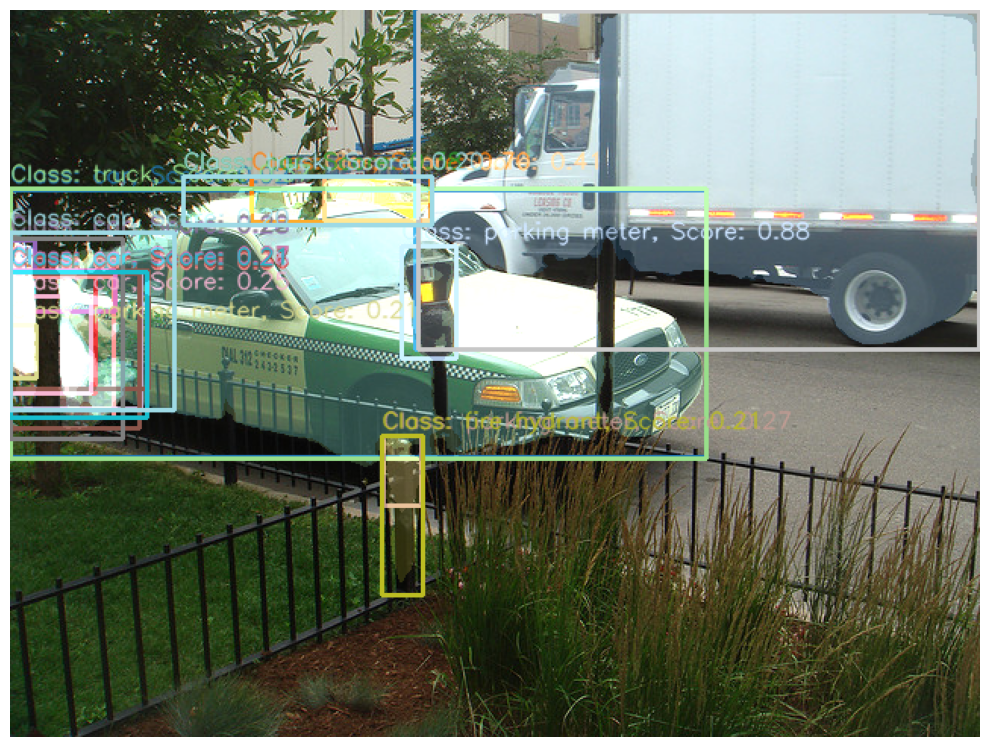

In [ ]:
import requests
import torchvision
from PIL import Image
import os

image_folder = '/home/prml3090/joohee/DATA/coco2017/coco2017/test2017/'
image_list = os.listdir(image_folder)
image_list = sorted(image_list)
image_path = os.path.join(image_folder, image_list[i])
image = Image.open(image_path)
i += 1

W, H = image.size
print(H, W)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640,640)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)

# 모델 forward pass
output = model(input_tensor)
print(output.keys())

post_output = postprocessor(output, torch.tensor([[W, H]]).to(device))
print(post_output[0].keys())

print(i)
visualize_all_high_score_objects(post_output=post_output[0], image_path=image_path, score_threshold=0.5)
